# 0. 课程前言
此为 <<人工智能安全>> 课程第四部分: 模型窃取攻击与防御实验部分.

**模型窃取攻击**的目标是通过一定手段窃取得到一个跟 受害者模型 功能和性能近似的窃取模型，从而避开昂贵的模型训练并从中获益。

<img src="./imgs/model steal.png" alt="替代模型窃取攻击示意图" style="height: 300px; max-width: 100%;">

上图为一个简单基础的模型窃取攻击过程，攻击者在黑盒环境下与受害者模型交互，获取模型的输入与输出，并不断调整查询样本来获取模型更多的决策边界信息。攻击者可以将此输入-输出作为数据集，对自己的模型进行模仿学习，得到一个与受害者模型相似的窃取模型。

一般来说，模型窃取攻击的主要目标包括：
1. 低代价：以远低于受害者模型训练成本的代价获得一个可免费使用的窃取模型；
2. 高收益：窃取得到的模型与受害者模型的功能和性能相当；
3. 低风险：在窃取过程中可以避开相关检测并在窃取后无法被溯源。

# 1. 模型窃取攻击
模型窃取攻击有多种方式：基于**方程式求解**的模型窃取攻击、基于**替代模型**的窃取攻击、基于**元模型**的窃取攻击。

受篇幅影响，本次实验主要将基于替代模型的窃取攻击，有兴趣的同学可自行搜索学习其他类别的攻击方法。

## 1.1 基于替代模型的窃取攻击
攻击主要思路：攻击者 $A$ 在不知道受害者模型 $f(\cdot)$ 任何先验知识情况下，向受害者模型输入查询样本 $x$ ，得到受害者模型的预测输出 $f(x)$ 。随后，攻击者根据输入和输出构建替代训练数据集 $\mathcal D ' = {(x, f(x))}^m_{i=1}$ 。

实际上，替代数据集已经完成了对袁术训练数据的（部分）提取。在替代数据集 $\mathcal D'$ 上多次训练后，即可得到一个与受害者模型 $f(\cdot)$ 功能和性质类似的替代模型 $f'(\cdot)$ ，完成模型窃取攻击。

<img src="./imgs/model steal2.png" alt="替代模型窃取攻击示意图" style="height: 400px; max-width: 100%;">



为了实现这样的模型窃取方法，我们首先需要加载受害者模型。

（在实际中，模型窃取攻击者通常使用受害者API进行查询访问）

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import os
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import datasets

import cifar_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [25]:
model_path = "./models/"
model_list = [
    "cifar10_resnet18.pth",
    "cifar10_model.pth"
]

# 加载模型
def load_model(model_path, num_classes, device):
    # 加载模型结构
    model = cifar_model.ResNet18(num_classes=num_classes)

    # 加载模型权重
    if device == 'cpu':
        state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    else:
        state_dict = torch.load(model_path)
    
    # 加载权重到模型
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()  # 设置为评估模式

    print("加载模型: ", model_path)
    return model

In [26]:
victim_model = load_model(model_path + model_list[0], num_classes=10, device=device)

加载模型:  ./models/cifar10_resnet18.pth


/tmp/ipykernel_1870033/168071617.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


对加载的受害者模型进行测试

In [27]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 加载CIFAR-10测试数据集
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=4, pin_memory=True)

Files already downloaded and verified


In [28]:
# 测试模型
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
def test_model(model, dataloader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    acc = 100.*correct/total
    return acc

In [29]:
print("Model Test Accuracy: ", test_model(victim_model, testloader), '%')

Model Test Accuracy:  95.28 %


接下来，我们作为攻击者，对受害者模型进行轮询访问，以获取其查询-预测对:

现在有一个问题：攻击者如何获取用于查询的数据集？

虽然在实际中，攻击者并不知道模型的任何先验知识，但是知道其功能是什么。举一个简单的例子：受害者模型是一个对猫狗的二分类问题，攻击者即可收集猫和狗的图像作为对模型的查询数据集。

在本次实验中，受害者模型是一个10-分类问题，简单起见，我们直接对 cifar-10 公开数据集进行随机采样，以作为对受害者模型的查询数据集。

In [106]:
def build_query_set(dataset_name="cifar10", data_size=10000, use_public_data=True):
    """构建用于查询受害者模型的数据集"""
    if use_public_data:
        if dataset_name == "cifar10":
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])
            query_dataset = torchvision.datasets.CIFAR10(
                root='./data', train=True, download=True, transform=transform)
            
            # 随机采样一部分数据
            indices = np.random.choice(len(query_dataset), data_size, replace=False)
            query_images = torch.stack([query_dataset[i][0] for i in indices])
            return query_images
    
    else:
        # 生成随机噪声数据
        return torch.randn(data_size, 3, 32, 32) * 0.5 + 0.5

于是，我们便可以使用查询数据集对受害者模型进行轮询：

In [107]:
def query_victim_model(victim_model, query_images, batch_size=64, device='cuda'):
    """向受害者模型发送查询并收集预测结果"""
    victim_model.to(device)
    victim_model.eval()
    
    all_predictions = []
    dataloader = DataLoader(query_images, batch_size=batch_size, shuffle=False)
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Querying victim model"):
            batch = batch.to(device)
            outputs = victim_model(batch)
            # 获取预测的类别
            _, predictions = torch.max(outputs, 1)
            all_predictions.append(predictions.cpu())
    
    # 合并所有批次的预测结果
    all_predictions = torch.cat(all_predictions)
    return all_predictions

将获取到的查询-预测对构建成为替代数据集，我们还可以使用数据增强对替代数据集进行增强：

In [108]:
class SubstituteDataset(Dataset):
    def __init__(self, queries, predictions, transform=None):
        self.queries = queries
        self.predictions = predictions
        self.transform = transform
        
    def __len__(self):
        return len(self.queries)
    
    def __getitem__(self, idx):
        img, prediction = self.queries[idx], self.predictions[idx]
        
        if isinstance(img, np.ndarray):
            img = torch.tensor(img)
            
        if self.transform:
            img = self.transform(img)
            
        return img, prediction

def create_substitute_dataset(victim_model, query_images, save_path="substitute_dataset.pt", augment=False):
    """构建并保存替代数据集"""
    # 查询受害者模型
    predictions = query_victim_model(victim_model, query_images)

    # # 定义数据增强
    # train_transform = transforms.Compose([
    #     transforms.ToPILImage(),
    #     transforms.RandomCrop(32, padding=4),
    #     transforms.RandomHorizontalFlip(),
    #     transforms.ToTensor(),
    #     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    # ])
    
    # 创建替代数据集
    substitute_dataset = SubstituteDataset(query_images, predictions, train_transform if augment else None)
    
    # 保存数据集
    torch.save({
        'queries': query_images,
        'predictions': predictions
    }, save_path)
    
    print(f"替代数据集已保存至: {save_path}")
    print(f"数据集大小: {len(substitute_dataset)} 样本")
    return substitute_dataset

In [109]:
# 构建查询集（使用CIFAR-10测试集的10000个样本）
query_images = build_query_set(data_size=10000)

# 创建替代数据集
substitute_dataset = create_substitute_dataset(
    victim_model=victim_model,
    query_images=query_images,
    save_path="substitute_dataset_cifar10.pt"
)

Files already downloaded and verified


Querying victim model: 100%|██████████| 157/157 [00:00<00:00, 394.91it/s]


替代数据集已保存至: substitute_dataset_cifar10.pt
数据集大小: 10000 样本


我们来看一下替代数据集是什么样的：

In [110]:
CIFAR10_CLASS_NAMES = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

def visualize_substitute_dataset(dataset, num_samples=5, class_names=CIFAR10_CLASS_NAMES):
    """可视化替代数据集中的样本，显示类别名称而非数字"""
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        # 反归一化以便显示
        image = image.permute(1, 2, 0).numpy()
        image = image * np.array([0.2023, 0.1994, 0.2010]) + np.array([0.4914, 0.4822, 0.4465])
        image = np.clip(image, 0, 1)
        
        # 获取类别名称
        class_name = class_names[label] if label < len(class_names) else f"Unknown ({label})"
        
        plt.subplot(1, num_samples, i+1)
        plt.imshow(image)
        plt.title(f"Predicted: {class_name}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

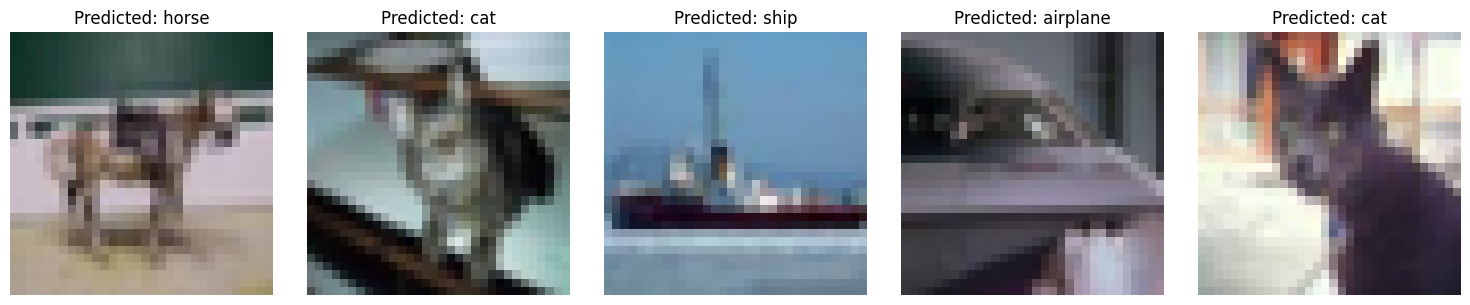

In [111]:
# 可视化样本
visualize_substitute_dataset(substitute_dataset)  

获取替代数据集后，我们便可以对自己的模型进行训练了。

作为攻击者，我们并不知道模型内部的架构，因此，我们需要自定义自己的模型架构。

In [112]:
class SubstituteModel(nn.Module):
    def __init__(self, num_classes=10):
        super(SubstituteModel, self).__init__()
        self.features = nn.Sequential(
            # 第一层卷积
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
            
            # 第二层卷积
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
            
            # 第三层卷积
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
        )
        
        # 全连接分类器
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [113]:
substitute_model = SubstituteModel(num_classes=10).to(device)

接下来，我们使用窃取构建的数据集对模型进行训练：

In [114]:
def train_substitute_model(substitute_model, substitute_dataset, epochs=50, batch_size=128, lr=0.001, device='cuda'):
    """在替代数据集上训练替代模型"""
    # 创建数据加载器
    train_loader = DataLoader(substitute_dataset, batch_size=batch_size, shuffle=True)
    
    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(substitute_model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    
    # 训练循环
    substitute_model.to(device)
    best_acc = 0.0
    
    for epoch in range(epochs):
        substitute_model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = substitute_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        # 计算准确率和平均损失
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        
        print(f'Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%')
        
        # 学习率调度
        scheduler.step(epoch_loss)
        
        # 保存最佳模型
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(substitute_model.state_dict(), 'substitute_model_best.pth')
            print(f'Saved best model with accuracy: {best_acc:.2f}%')
    
    print(f'Finished training. Best accuracy: {best_acc:.2f}%')
    return substitute_model

In [116]:
# 在替代数据集上训练替代模型
print("开始训练替代模型...")
trained_substitute_model = train_substitute_model(
    substitute_model=substitute_model,
    substitute_dataset=substitute_dataset,
    epochs=100,
    device=device
)

开始训练替代模型...
Epoch 1/100 | Loss: 0.5103 | Acc: 81.66%
Saved best model with accuracy: 81.66%
Epoch 2/100 | Loss: 0.4659 | Acc: 83.58%
Saved best model with accuracy: 83.58%
Epoch 3/100 | Loss: 0.4395 | Acc: 83.89%
Saved best model with accuracy: 83.89%
Epoch 4/100 | Loss: 0.4021 | Acc: 85.82%
Saved best model with accuracy: 85.82%
Epoch 5/100 | Loss: 0.3872 | Acc: 86.31%
Saved best model with accuracy: 86.31%
Epoch 6/100 | Loss: 0.3409 | Acc: 87.96%
Saved best model with accuracy: 87.96%
Epoch 7/100 | Loss: 0.3110 | Acc: 89.40%
Saved best model with accuracy: 89.40%
Epoch 8/100 | Loss: 0.3348 | Acc: 88.18%
Epoch 9/100 | Loss: 0.2887 | Acc: 89.69%
Saved best model with accuracy: 89.69%
Epoch 10/100 | Loss: 0.2813 | Acc: 90.30%
Saved best model with accuracy: 90.30%
Epoch 11/100 | Loss: 0.2648 | Acc: 90.66%
Saved best model with accuracy: 90.66%
Epoch 12/100 | Loss: 0.2755 | Acc: 90.20%
Epoch 13/100 | Loss: 0.2328 | Acc: 91.93%
Saved best model with accuracy: 91.93%
Epoch 14/100 | Loss: 0

接下来，我们对窃取数据集上训练的模型进行评估：

In [117]:
print("Model Test Accuracy: ", test_model(substitute_model, testloader), '%')

Model Test Accuracy:  80.04 %


可以发现，窃取模型攻击所获取的模型的测试准确率非常高，这样，攻击者就可以用极低的时间和训练成本来获取一个高质量的模型。